In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Definindo diretório para checkpoints

In [3]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Criando um gerador de dados que aplicará técnicas de data augmentation ao dataset.

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  fill_mode='nearest',
  zoom_range=0.3,
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=30)

Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [5]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma função que retornará um modelo com base na arquitetura DenseNet 201, treinada com os pesos da ImageNet, sem a camada superior, de classificação. É adicionada ao modelo uma camada Fully Connected para a classificação dos 50 labels.

In [9]:
def getModel():
  base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
  )

  base_model.trainable = True
  
  model = tf.keras.Sequential([
      base_model,  # 1
      tf.keras.layers.GlobalAveragePooling2D(),  # 4
      tf.keras.layers.Dense(50, activation='softmax')  # 5
  ])

  model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.0001, momentum=0.9),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3

  return model

Utilizando Stratified 5-fold Cross-validation para treinamento/validação do modelo

In [10]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Carregando nomes dos arquivos de imagem e seus respectivos rótulos

In [11]:
filenames = []
labels    = []

for classname in os.listdir(base_dir):
  class_dir = os.path.join(base_dir, classname)
  if os.path.isdir(class_dir):
    for filename in os.listdir(class_dir):
      if filename.lower().endswith(".jpg"):
        labels.append(classname)
        filenames.append(os.path.join(class_dir, filename))

filenames = np.array(filenames)
labels    = np.array(labels)

Mostrando histograma do dataset utilizado

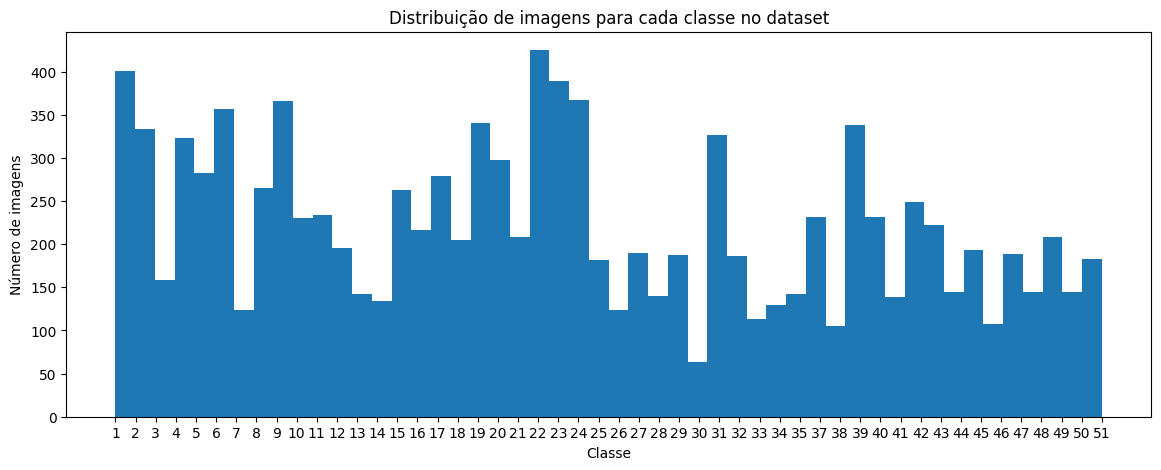

In [40]:
plt.figure(figsize=(14, 5))

sorted_labels = sorted(labels, key=lambda x: int(x))

plt.hist(sorted_labels, density=False, bins=50)
plt.ylabel('Número de imagens')
plt.xlabel('Classe')
plt.title('Distribuição de imagens para cada classe no dataset')

plt.show()

Definindo as épocas para o treinamento da model

In [12]:
epochs = 20
history_list = []

Escreve divisão do dataset da validação cruzada em um arquivo

In [13]:
import json

folds_training_validation = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(filenames, labels)):
  fold_resultado = {
    "fold": fold + 1,
    "training": {
      "indexes": train_index.tolist(),
      "data": filenames[train_index].tolist(),
      "labels": labels[train_index].tolist()
    },
    "validation": {
      "indexes": val_index.tolist(),
      "data": filenames[val_index].tolist(),
      "labels": labels[val_index].tolist()
    }
  }
  folds_training_validation.append(fold_resultado)

# Converter para JSON
json_resultado = json.dumps(folds_training_validation, indent=2)

with open('cross_validation_folds.json', 'w') as file:
  file.write(json_resultado)

Define o último fold usado para treinamento/validação:

In [17]:
last_fold = 0

Aplicando o Stratified 10-fold Cross-Validation

In [18]:
folds_training_validation_from_last_fold = folds_training_validation[last_fold:]
for fold in folds_training_validation_from_last_fold:
  print(f"Fold {fold['fold']}/{n_folds}")

  # Separando os dados de treinamento e validação
  train_filenames = fold['training']['data']
  train_labels = fold['training']['labels']

  val_filenames = fold['validation']['data']
  val_labels = fold['validation']['labels']

  # Criando geradores de dados de treinamento e validação
  train_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": train_filenames, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  val_generator = data_generator.flow_from_dataframe(
    pd.DataFrame({"filename": val_filenames, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
  )

  model = getModel()

  # Treinando o modelo
  history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)
  history_list.append(history.history)

  json_history = json.dumps(history_list, indent=2)
  with open('history_list.json', 'w') as file:
    file.write(json_history)
  
  last_fold += 1

Fold 4/5
Found 8920 validated image filenames belonging to 50 classes.
Found 2230 validated image filenames belonging to 50 classes.
Epoch 1/20


2023-11-25 19:08:15.798127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - ETA: 0s - loss: 3.4988 - accuracy: 0.1937

2023-11-25 19:23:48.077396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - 1030s 4s/step - loss: 3.4988 - accuracy: 0.1937 - val_loss: 2.8343 - val_accuracy: 0.4269
Epoch 2/20
279/279 [==============================] - 1079s 4s/step - loss: 2.3047 - accuracy: 0.5660 - val_loss: 1.6888 - val_accuracy: 0.6628
Epoch 3/20
279/279 [==============================] - 1057s 4s/step - loss: 1.5318 - accuracy: 0.7198 - val_loss: 1.1731 - val_accuracy: 0.7901
Epoch 4/20
279/279 [==============================] - 1067s 4s/step - loss: 1.0905 - accuracy: 0.8182 - val_loss: 0.8403 - val_accuracy: 0.8570
Epoch 5/20
279/279 [==============================] - 1066s 4s/step - loss: 0.8143 - accuracy: 0.8713 - val_loss: 0.6232 - val_accuracy: 0.9049
Epoch 6/20
279/279 [==============================] - 1090s 4s/step - loss: 0.6370 - accuracy: 0.9043 - val_loss: 0.4844 - val_accuracy: 0.9202
Epoch 7/20
279/279 [==============================] - 1090s 4s/step - loss: 0.5088 - accuracy: 0.9248 - val_loss: 0.4013 - val_accuracy: 0.9336
Epo

2023-11-26 00:49:38.880136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - ETA: 0s - loss: 3.4963 - accuracy: 0.1956

2023-11-26 01:07:25.438658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - 1189s 4s/step - loss: 3.4963 - accuracy: 0.1956 - val_loss: 2.8398 - val_accuracy: 0.4121
Epoch 2/20
279/279 [==============================] - 1018s 4s/step - loss: 2.3143 - accuracy: 0.5504 - val_loss: 1.7265 - val_accuracy: 0.6655
Epoch 3/20
279/279 [==============================] - 1016s 4s/step - loss: 1.5583 - accuracy: 0.7099 - val_loss: 1.1788 - val_accuracy: 0.7771
Epoch 4/20
279/279 [==============================] - 996s 4s/step - loss: 1.1075 - accuracy: 0.8118 - val_loss: 0.8580 - val_accuracy: 0.8507
Epoch 5/20
279/279 [==============================] - 1006s 4s/step - loss: 0.8248 - accuracy: 0.8677 - val_loss: 0.6398 - val_accuracy: 0.8933
Epoch 6/20
279/279 [==============================] - 1020s 4s/step - loss: 0.6467 - accuracy: 0.8981 - val_loss: 0.4975 - val_accuracy: 0.9103
Epoch 7/20
279/279 [==============================] - 1019s 4s/step - loss: 0.5175 - accuracy: 0.9196 - val_loss: 0.3849 - val_accuracy: 0.9381
Epoc

Mostrando as métricas em um gráfico

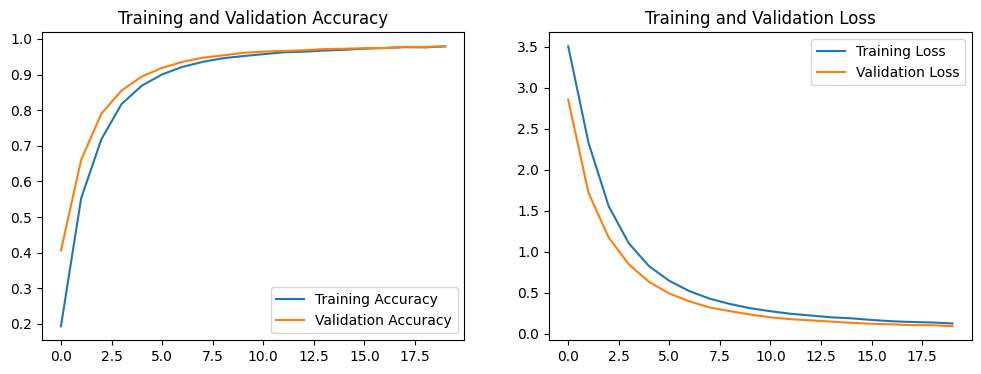

In [19]:
grupo_acc_index       = list(zip(*(d['accuracy'] for d in history_list)))
grupo_loss_index      = list(zip(*(d['val_accuracy'] for d in history_list)))
grupo_val_acc_index   = list(zip(*(d['loss'] for d in history_list)))
grupo_val_loss_index  = list(zip(*(d['val_loss'] for d in history_list)))

acc_values      = [sum(values) / len(values) for values in grupo_acc_index]
val_acc_values  = [sum(values) / len(values) for values in grupo_loss_index]
loss_values     = [sum(values) / len(values) for values in grupo_val_acc_index]
val_loss_values = [sum(values) / len(values) for values in grupo_val_loss_index]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()